In [1]:
import torch
torch.cuda.is_available()

/mnt/work/python/dkottke/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import os
import tempfile

from torch.utils.data import DataLoader

from torchgeo.datasets import NAIP, ChesapeakeDE, stack_samples
from torchgeo.datasets.utils import download_url
from torchgeo.samplers import RandomGeoSampler


In [6]:
data_root = tempfile.gettempdir()
naip_root = os.path.join(data_root, "naip")
naip_url = (
    "https://naipeuwest.blob.core.windows.net/naip/v002/de/2018/de_060cm_2018/38075/"
)
tiles = [
    "m_3807511_ne_18_060_20181104.tif",
    "m_3807511_se_18_060_20181104.tif",
    "m_3807512_nw_18_060_20180815.tif",
    "m_3807512_sw_18_060_20180815.tif",
]
for tile in tiles:
    download_url(naip_url + tile, naip_root)

naip = NAIP(naip_root)


100%|██████████| 513332284/513332284 [00:19<00:00, 26103824.37it/s]


100%|██████████| 521985441/521985441 [00:13<00:00, 38704241.81it/s]


100%|██████████| 489865657/489865657 [00:11<00:00, 41878373.77it/s]


100%|██████████| 484476647/484476647 [00:13<00:00, 36230561.40it/s]


In [7]:
chesapeake_root = os.path.join(data_root, "chesapeake")

chesapeake = ChesapeakeDE(chesapeake_root, crs=naip.crs, res=naip.res, download=True)


100%|██████████| 287350495/287350495 [00:36<00:00, 7952730.46it/s] 


In [8]:
dataset = naip & chesapeake


In [155]:
chesapeake.__

'torchgeo.datasets'

In [109]:
naip

In [94]:
DATASET_SIZE = 100

sampler = RandomGeoSampler(naip, size=128, length=DATASET_SIZE)


In [95]:
BATCH_SIZE=32

dataloader = DataLoader(dataset, BATCH_SIZE, sampler=sampler, collate_fn=stack_samples)

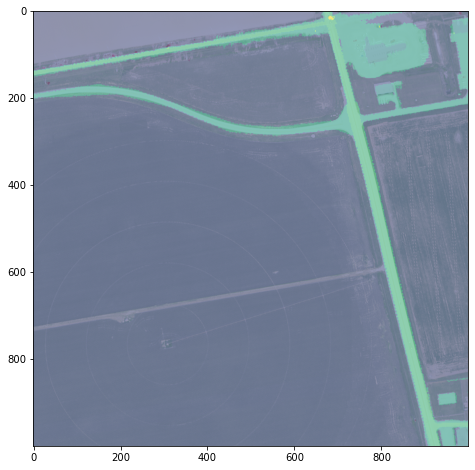

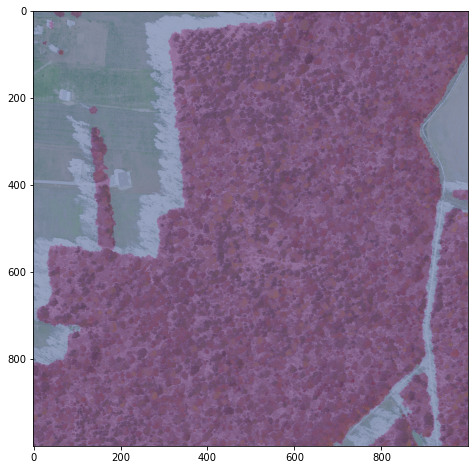

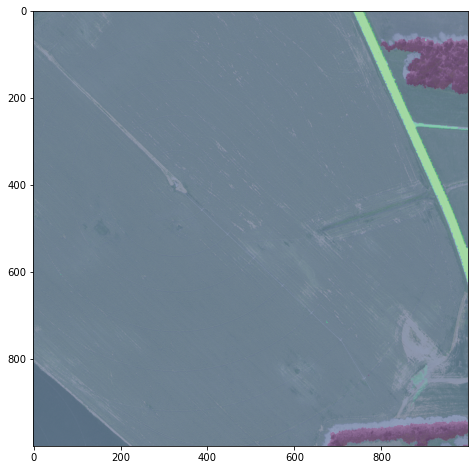

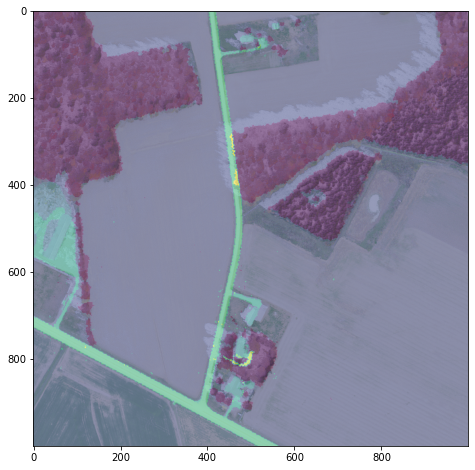

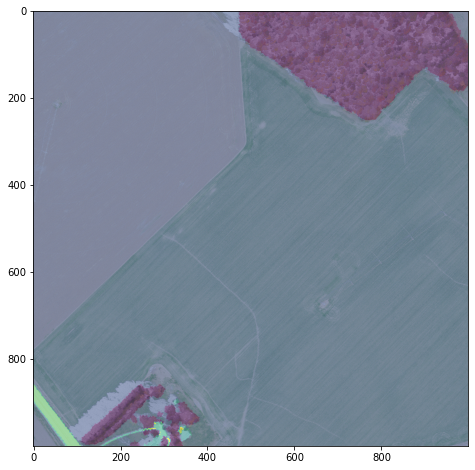

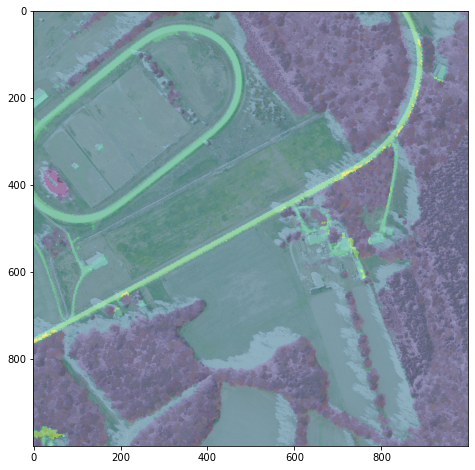

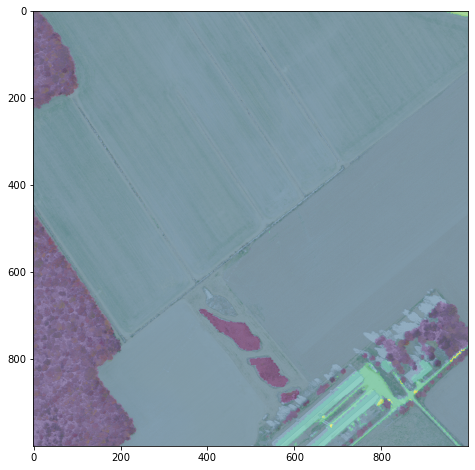

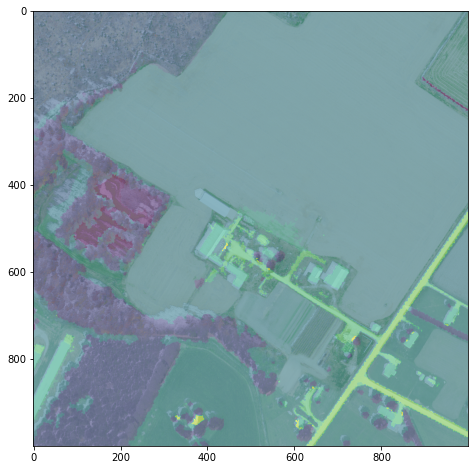

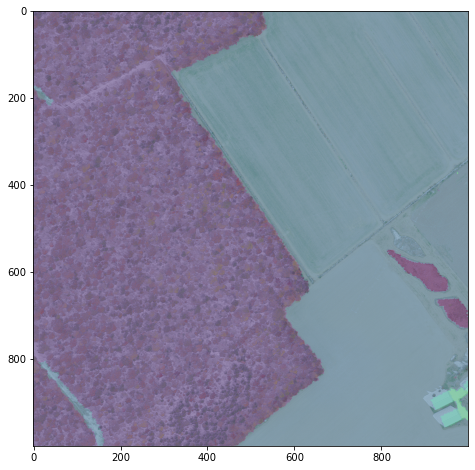

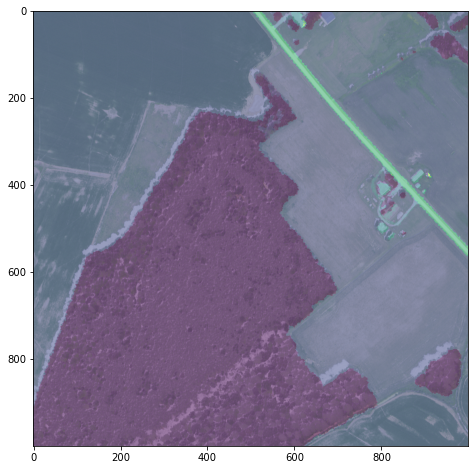

In [56]:
sampler = RandomGeoSampler(naip, size=128, length=DATASET_SIZE)

dataloader = DataLoader(dataset, BATCH_SIZE, sampler=sampler, collate_fn=stack_samples)

for sample in dataloader:
    image = sample["image"]
    target = sample["mask"]
    
    visualize(image, target)


In [104]:
# sanity check
images, masks = next(iter(dataloader))['image'], next(iter(dataloader))['mask']
images.shape, masks.shape
images

tensor([[[[ 60,  50,  66,  ..., 148, 148, 119],
          [ 66,  76,  36,  ..., 157, 145, 130],
          [ 33,  75,  60,  ..., 130, 121, 119],
          ...,
          [ 95,  55,  80,  ..., 134, 138, 136],
          [130,  70,  75,  ..., 122, 122, 143],
          [167, 141,  92,  ..., 146, 122, 137]],

         [[ 56,  49,  53,  ..., 124, 125, 106],
          [ 67,  80,  45,  ..., 131, 120, 104],
          [ 57,  67,  70,  ..., 121, 113, 104],
          ...,
          [ 87,  71,  83,  ..., 122, 129, 117],
          [119,  83,  66,  ..., 120, 118, 120],
          [148, 105,  65,  ..., 134, 113, 122]],

         [[ 71,  48,  56,  ..., 110, 113,  99],
          [ 36,  68,  40,  ..., 105, 108,  86],
          [ 68,  62,  61,  ..., 104, 114,  97],
          ...,
          [ 67,  59,  77,  ..., 106, 102, 107],
          [ 98,  68,  67,  ..., 101, 104, 106],
          [116,  80,  69,  ..., 113,  96, 107]],

         [[ 66,  72,  50,  ..., 123, 128, 104],
          [125, 120,  91,  ..., 124, 

In [73]:
masks.max()

tensor(12, dtype=torch.uint8)

In [71]:
import segmentation_models_pytorch as smp

ENCODER          = 'resnet18'
#ENCODER_WEIGHTS  = 'imagenet'
CLASSES          = ['mask']
ACTIVATION       = None 

model = smp.Unet(
    encoder_name=ENCODER, 
    #encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

In [72]:
# define the test split
TEST_SPLIT = 0.15
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

In [84]:
# define the number of channels in the input, number of classes,
# and number of levels in the U-Net model
NUM_CHANNELS = 4
NUM_CLASSES = 12
NUM_LEVELS = 3
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 0.001
NUM_EPOCHS = 40
BATCH_SIZE = 64
# define the input image dimensions
INPUT_IMAGE_WIDTH = 128
INPUT_IMAGE_HEIGHT = 128
# define threshold to filter weak predictions
THRESHOLD = 0.5
# define the path to the base output directory
BASE_OUTPUT = "output"
# define the path to the output serialized model, model training
# plot, and testing image paths
MODEL_PATH = os.path.join(BASE_OUTPUT, "unet_tgs_salt.pth")
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])

In [86]:
# import the necessary packages
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torchvision.transforms import CenterCrop
from torch.nn import functional as F
import torch

class Block(Module):
    def __init__(self, inChannels, outChannels):
        super().__init__()
        # store the convolution and RELU layers
        self.conv1 = Conv2d(inChannels, outChannels, 3)
        self.relu = ReLU()
        self.conv2 = Conv2d(outChannels, outChannels, 3)
    def forward(self, x):
        # apply CONV => RELU => CONV block to the inputs and return it
        return self.conv2(self.relu(self.conv1(x)))
    
class Encoder(Module):
    def __init__(self, channels=(3, 16, 32, 64)):
        super().__init__()
        # store the encoder blocks and maxpooling layer
        self.encBlocks = ModuleList(
            [Block(channels[i], channels[i + 1])
                 for i in range(len(channels) - 1)])
        self.pool = MaxPool2d(2)
    def forward(self, x):
        # initialize an empty list to store the intermediate outputs
        blockOutputs = []
        # loop through the encoder blocks
        for block in self.encBlocks:
            # pass the inputs through the current encoder block, store
            # the outputs, and then apply maxpooling on the output
            x = block(x)
            blockOutputs.append(x)
            x = self.pool(x)
        # return the list containing the intermediate outputs
        return blockOutputs
    
class Decoder(Module):
    def __init__(self, channels=(64, 32, 16)):
        super().__init__()
        # initialize the number of channels, upsampler blocks, and
        # decoder blocks
        self.channels = channels
        self.upconvs = ModuleList(
            [ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
                 for i in range(len(channels) - 1)])
        self.dec_blocks = ModuleList(
            [Block(channels[i], channels[i + 1])
                 for i in range(len(channels) - 1)])
    def forward(self, x, encFeatures):
        # loop through the number of channels
        for i in range(len(self.channels) - 1):
            # pass the inputs through the upsampler blocks
            x = self.upconvs[i](x)
            # crop the current features from the encoder blocks,
            # concatenate them with the current upsampled features,
            # and pass the concatenated output through the current
            # decoder block
            encFeat = self.crop(encFeatures[i], x)
            x = torch.cat([x, encFeat], dim=1)
            x = self.dec_blocks[i](x)
        # return the final decoder output
        return x
    def crop(self, encFeatures, x):
        # grab the dimensions of the inputs, and crop the encoder
        # features to match the dimensions
        (_, _, H, W) = x.shape
        encFeatures = CenterCrop([H, W])(encFeatures)
        # return the cropped features
        return encFeatures
    
class UNet(Module):
    def __init__(self, encChannels=(3, 16, 32, 64),
            decChannels=(64, 32, 16),
            nbClasses=1, retainDim=True,
            outSize=(INPUT_IMAGE_HEIGHT,  INPUT_IMAGE_WIDTH)):
        super().__init__()
        # initialize the encoder and decoder
        self.encoder = Encoder(encChannels)
        self.decoder = Decoder(decChannels)
        # initialize the regression head and store the class variables
        self.head = Conv2d(decChannels[-1], nbClasses, 1)
        self.retainDim = retainDim
        self.outSize = outSize
        
    def forward(self, x):
        # grab the features from the encoder
        encFeatures = self.encoder(x)
        # pass the encoder features through decoder making sure that
        # their dimensions are suited for concatenation
        decFeatures = self.decoder(encFeatures[::-1][0],
            encFeatures[::-1][1:])
        # pass the decoder features through the regression head to
        # obtain the segmentation mask
        map = self.head(decFeatures)
        # check to see if we are retaining the original output
        # dimensions and if so, then resize the output to match them
        if self.retainDim:
            map = F.interpolate(map, self.outSize)
        # return the segmentation map
        return map

In [102]:
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
import time
from tqdm import tqdm

# initialize our UNet model
unet = UNet(encChannels=(4, 16, 32, 64)).to(DEVICE)

# initialize loss function and optimizer
lossFunc = BCEWithLogitsLoss()
opt = Adam(unet.parameters(), lr=INIT_LR)

# calculate steps per epoch for training and test set
trainSteps = DATASET_SIZE // BATCH_SIZE
testSteps = DATASET_SIZE // BATCH_SIZE

# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

In [107]:
NUM_EPOCHS = 10

# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(NUM_EPOCHS)):
    # set the model in training mode
    unet.train()
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalTestLoss = 0
    # loop over the training set
    for (i, data) in enumerate(dataloader):
        x = data['image'].float()
        y = data['mask'].float()
        # send the input to the device
        (x, y) = (x.to(DEVICE), y.to(DEVICE))
        # perform a forward pass and calculate the training loss
        pred = unet(x)
        loss = lossFunc(pred, y)
        # first, zero out any previously accumulated gradients, then
        # perform backpropagation, and then update model parameters
        opt.zero_grad()
        loss.backward()
        opt.step()
        # add the loss to the total training loss so far
        totalTrainLoss += loss
    # switch off autograd
    with torch.no_grad():
        # set the model in evaluation mode
        unet.eval()
        # loop over the validation set
        for (i, data) in enumerate(dataloader):
            x = data['image'].float()
            y = data['mask'].float()
            # send the input to the device
            (x, y) = (x.to(DEVICE), y.to(DEVICE))
            # make the predictions and calculate the validation loss
            pred = unet(x)
            totalTestLoss += lossFunc(pred, y)
    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgTestLoss = totalTestLoss / testSteps
    # update our training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
    print("Train loss: {:.6f}, Test loss: {:.4f}".format(
        avgTrainLoss, avgTestLoss))
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
    endTime - startTime))

[INFO] training the network...


 10%|█         | 1/10 [00:02<00:20,  2.30s/it]

[INFO] EPOCH: 1/10
Train loss: -281.866455, Test loss: -1117.1995


 20%|██        | 2/10 [00:04<00:16,  2.02s/it]

[INFO] EPOCH: 2/10
Train loss: -5799.620117, Test loss: -27260.5469


 30%|███       | 3/10 [00:05<00:13,  1.91s/it]

[INFO] EPOCH: 3/10
Train loss: -120427.656250, Test loss: -515550.8438


 40%|████      | 4/10 [00:07<00:10,  1.79s/it]

[INFO] EPOCH: 4/10
Train loss: -1802110.000000, Test loss: -7246452.0000


 50%|█████     | 5/10 [00:08<00:07,  1.59s/it]

[INFO] EPOCH: 5/10
Train loss: -22998372.000000, Test loss: -80482008.0000


 60%|██████    | 6/10 [00:10<00:05,  1.47s/it]

[INFO] EPOCH: 6/10
Train loss: -171351712.000000, Test loss: -665285376.0000


 70%|███████   | 7/10 [00:10<00:03,  1.31s/it]

[INFO] EPOCH: 7/10
Train loss: -1780256768.000000, Test loss: -4799493632.0000


 80%|████████  | 8/10 [00:11<00:02,  1.20s/it]

[INFO] EPOCH: 8/10
Train loss: -10713167872.000000, Test loss: -30339438592.0000


 90%|█████████ | 9/10 [00:12<00:01,  1.10s/it]

[INFO] EPOCH: 9/10
Train loss: -58144993280.000000, Test loss: -186472595456.0000


100%|██████████| 10/10 [00:13<00:00,  1.37s/it]

[INFO] EPOCH: 10/10
Train loss: -361415540736.000000, Test loss: -828248686592.0000
[INFO] total time taken to train the model: 13.74s


In [190]:
from torchgeo.datasets import RasterDataset

# base path of the dataset
DATASET_PATH = os.path.join("Data", "Train")

# define the path to the images and masks dataset
IMAGE_DATASET_PATH = os.path.join(DATASET_PATH, "Images")
MASK_DATASET_PATH = os.path.join(DATASET_PATH, "Labels")

class BengaluruDataset(RasterDataset):
    """
    Load xView3 polarization data that ends in *_dB.tif
    """

    filename_glob = "*.tif"
    

class BengaluruDatasetLabels(RasterDataset):
    """
    Load xView3 polarization data that ends in *_dB.tif
    """
    is_image = False
    filename_glob = "*.tif"

In [191]:
ds = BengaluruDataset(IMAGE_DATASET_PATH)
la = BengaluruDatasetLabels(MASK_DATASET_PATH)

dataset = ds & la

Converting BengaluruDatasetLabels resolution from 1.200444240953174 to 1.2004442409532352


In [192]:
ds.bounds

BoundingBox(minx=777759.1886599514, maxx=782700.2171571326, miny=1451999.108340685, maxy=1480999.4403944414, mint=0.0, maxt=9.223372036854776e+18)

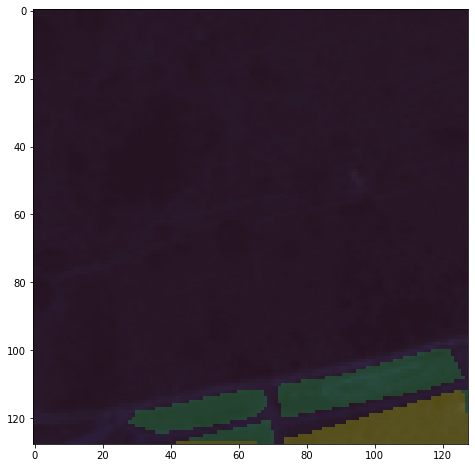

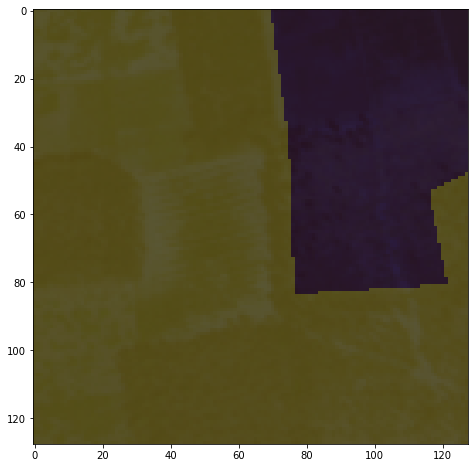

In [200]:
DATASET_SIZE = 2
BATCH_SIZE = 1

sampler = RandomGeoSampler(dataset, size=128, length=DATASET_SIZE)

dataloader = DataLoader(dataset, BATCH_SIZE, sampler=sampler, collate_fn=stack_samples)

import pylab as plt

def visualize(image, mask):
    """PLot images in one row."""
    plt.figure(figsize=(16, 8))
    #plt.imshow(image[0].transpose(0,2), vmin=0, vmax=1)
    plt.imshow(image[0].transpose(0,2))
    #plt.imshow(image[0])
    if mask.max()>0:
        plt.imshow(mask[0].transpose(0,2), alpha=0.25)
    plt.show()


for sample in dataloader:
    image = sample["image"][:, :3, :, :]
    target = sample["mask"]
    
    visualize(image, target)


In [128]:
target

[]

In [ ]:
# import the necessary packages
from torch.utils.data import Dataset

class BengaluruDataset(Dataset):
    def __init__(self, imagePaths, maskPaths, transforms):
        # store the image and mask filepaths, and augmentation
        # transforms
        self.imagePaths = imagePaths
        self.maskPaths = maskPaths
        self.transforms = transforms
        
    def __len__(self):
        # return the number of total samples contained in the dataset
        return len(self.imagePaths)
    
    def __getitem__(self, idx):
        # grab the image path from the current index
        imagePath = self.imagePaths[idx]
        # load the image from disk, swap its channels from BGR to RGB,
        # and read the associated mask from disk in grayscale mode
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.maskPaths[idx], 0)
        # check to see if we are applying any transformations
        if self.transforms is not None:
            # apply the transformations to both image and its mask
            image = self.transforms(image)
            mask = self.transforms(mask)
        # return a tuple of the image and its mask
        return (image, mask)